<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/merge_set_4class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [1]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 492, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 492 (delta 92), reused 184 (delta 92), pack-reused 307
Receiving objects: 100% (492/492), 16.74 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (269/269), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 45.5 MB 34.6 MB/s 0:00:03
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30867 sha256=8eeb4081694e708de457bad42d3a09f6a80da2db6a18b6948eb4fbf57644e9f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ar52mhc8/wheels/bd/4e/e5/83b4f2372d9ebd5ff8a9186f325c3b4df10c970348e640c493
Successfully built keras-vis
  Attempting uninstall: keras-vis
    Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


Unpack the items

In [4]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
#!unzip -q /content/drive/My\ Drive/obj/data_6class
!rm -rf merge
!unzip -q /content/drive/My\ Drive/merge


# Load libraries
Load the necessary libraries

In [5]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns
import random


from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [6]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(8, 80, 224, 224, 3) (8, 40, 224, 224, 3)
(8, 80, 224, 224, 3) (8, 40, 224, 224, 3)


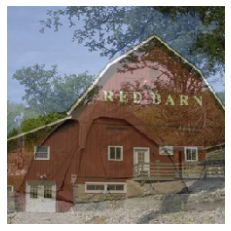

In [7]:
# Merged images load
data_train = [[]  for i in range(8)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
#data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
#data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[4] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
#data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
#data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(8)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
#data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
#data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[4] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
#data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
#data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[3,74])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(8)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
#reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
#reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[4] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
#reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
#reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(8)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
#reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
#reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[4] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
#reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
#reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



# Model
Call the base model and the top model here

### Model Architecture

In [8]:

# Calling VGG16 without the top FC layers with weights loaded from imagenet 
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest)

losses = 'categorical_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


58889256/58889256 [==============================] - 2s 0us/step
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
5/5 [==============================] - 10s 84ms/step
Train Time: 10.263498783111572
3/3 [==============================] - 2s 855ms/step


Test Time: 1.95735764503479
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 top_dense1 (Dense)          (None, 4096)              102764544 
                                                                 
 predictions (Dense)         (None, 2)                 8194      
                                                                 
Total params: 102,772,738
Trainable params: 102,772,738
Non-trainable params: 0
_________________________________________________________________


### Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [ ]:
acc = np.zeros((2,4))
for imtype in range(2):
  for cat in range(4):
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 4])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
    print(train_it.shape,test_it.shape)

    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:])) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
    top_model.add(Dense(2, activation='softmax',name = 'predictions'))

    top_model.compile(optimizer= Adam(lr=1e-5),
                  loss=losses,
                  metrics=['accuracy'])
    start = time.time()
    train_data = model.predict(train_it) 
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it) 
    print(f'Test Time: {time.time() - start}')
    
    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

In [ ]:
diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns
plt.rcParams['figure.dpi'] = 72
sns.color_palette('pastel')
sns.set(font_scale=2,style="ticks")
plt.figure(figsize = (4,8),tight_layout = True)
ax = sns.boxplot(data = acc.T*100 )
#ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 20)
ax.set_ylim(50,100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylabel('Binary Classification Acc.',size = 20)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])




# Tuning Value Calculation

In [ ]:
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(len(categories)): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)

### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(len(categories)): 
  with open ('tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



320

### Calculation of tuning values for each map

In [ ]:
ncats = len(categories)
# to fish out each category tun_activations
labels = np.array([0] * 80 + [1] * 80 + [2] * 80 + [3] * 80 )
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]

### Tuning quality

(0.0, 10.0)

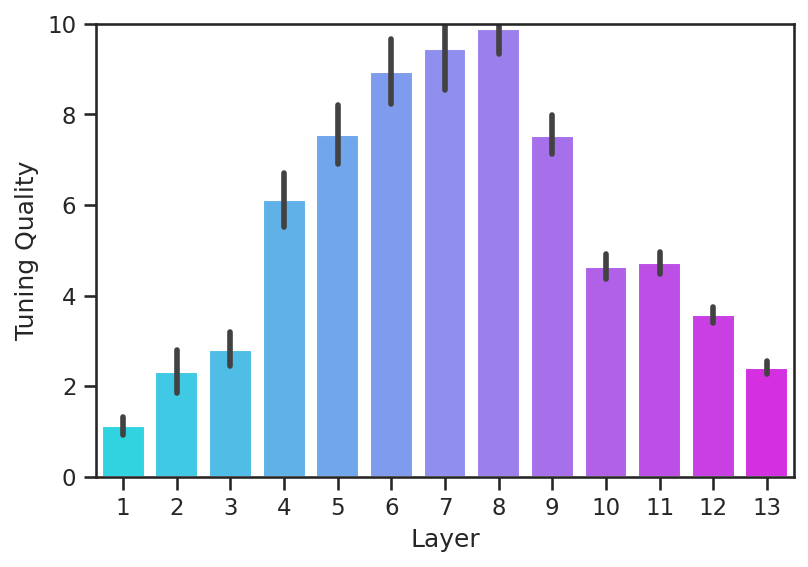

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="ticks")
ax = sns.barplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,10])

### Tuning quality for face and scene images

In [ ]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < fc[cat][layer][map]:
        tun_q_face[layer][map] = fc[cat][layer][map]


tun_q_scene = [[0 for item in subl] for subl in fc[0]]
for cat in range(2,4):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_scene[layer][map] < fc[cat][layer][map]:
        tun_q_scene[layer][map] = fc[cat][layer][map]

### T-test to check differences

In [ ]:
## T-test to check differences
P = [[] for i in range(13)]
import scipy.stats as stats
for cat in range(len(tun_q_face)):
  print(stats.ttest_rel(tun_q_scene[cat],tun_q_face[cat]))
# significant differences from layer 3 to layer 12

Ttest_relResult(statistic=0.12957729118149305, pvalue=0.8973136942519867)
Ttest_relResult(statistic=1.2338528968310367, pvalue=0.2218409849011659)
Ttest_relResult(statistic=3.0462834445855735, pvalue=0.002818358652023418)
Ttest_relResult(statistic=8.437890041127902, pvalue=6.186139389780104e-14)
Ttest_relResult(statistic=4.130704861356351, pvalue=4.9063899770364065e-05)
Ttest_relResult(statistic=5.89676909068821, pvalue=1.1714968843298434e-08)
Ttest_relResult(statistic=6.13418110569221, pvalue=3.2465729624941864e-09)
Ttest_relResult(statistic=7.54565458868077, pvalue=2.0775193906246656e-13)
Ttest_relResult(statistic=7.517397098335639, pvalue=2.5243611482218836e-13)
Ttest_relResult(statistic=5.279747909618692, pvalue=1.9165028001510888e-07)
Ttest_relResult(statistic=4.95552547534843, pvalue=9.825393235360608e-07)
Ttest_relResult(statistic=6.328582108687344, pvalue=5.415647278882855e-10)
Ttest_relResult(statistic=1.6432554869818445, pvalue=0.10094520107173047)


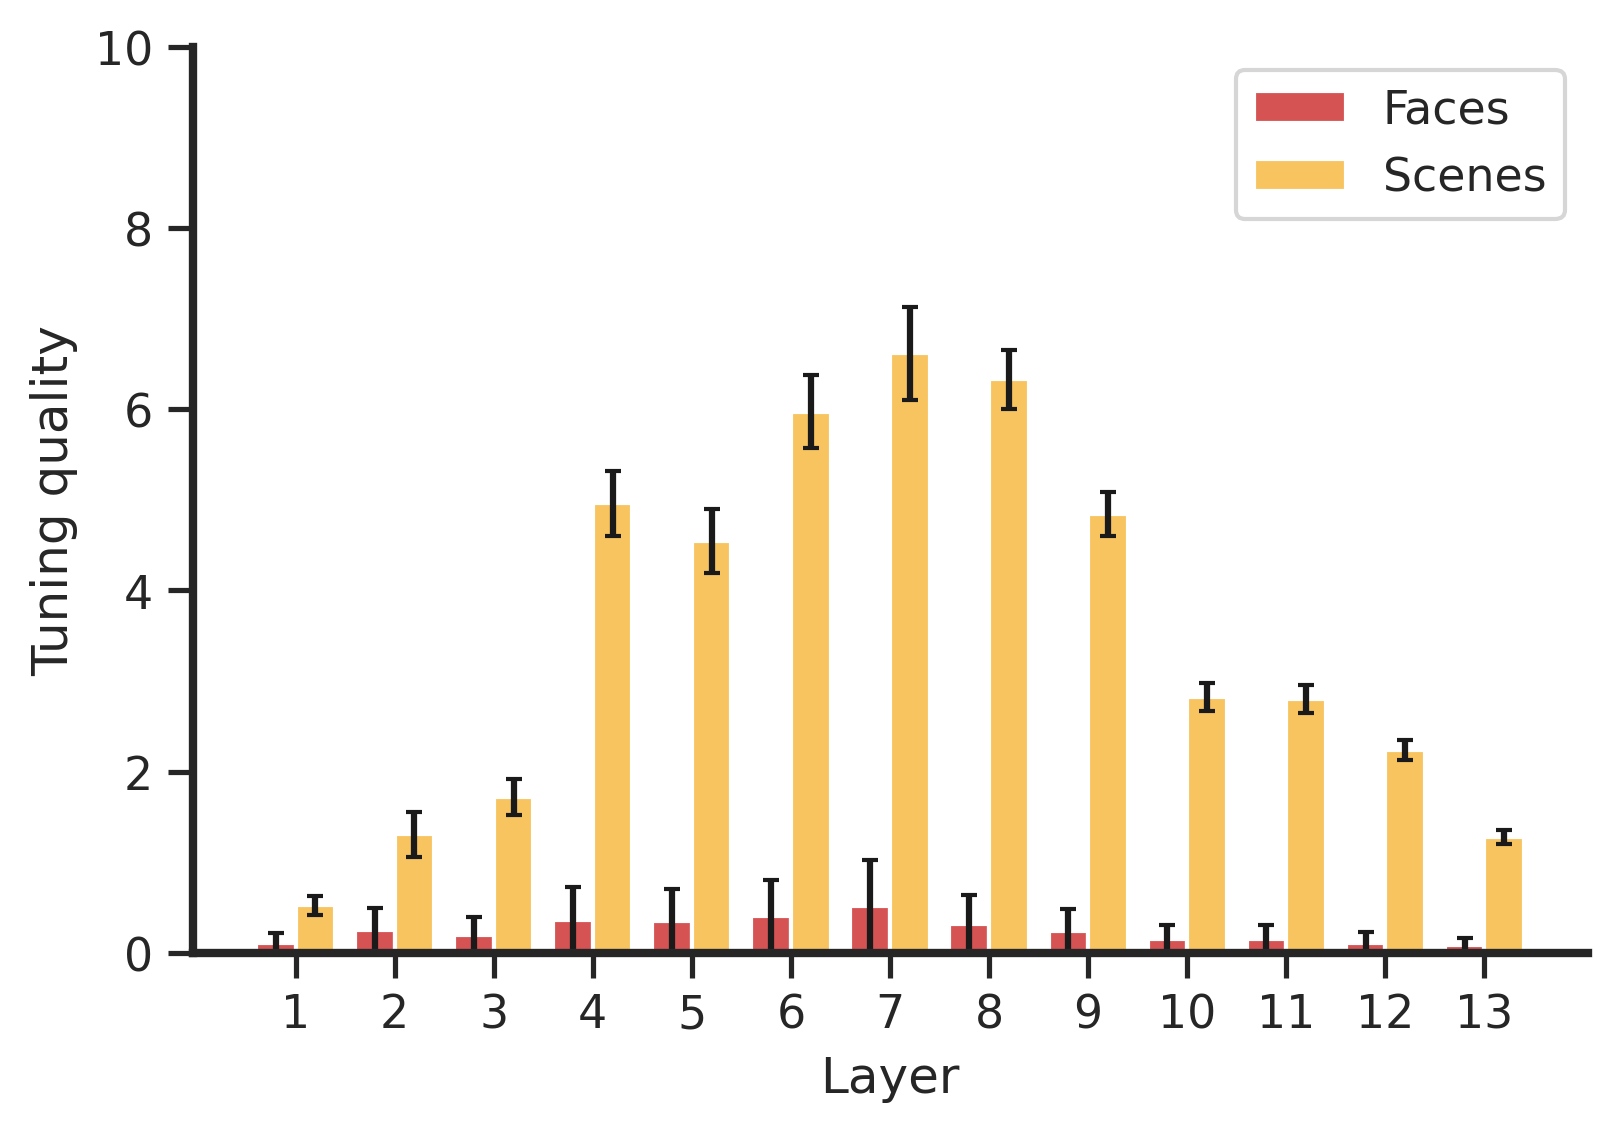

In [ ]:
plt.rcParams['figure.dpi'] = 72

m = np.empty([13])
n = np.empty([13])
merr = m
nerr = m

r1 = np.arange(13)
barW = 0.4
r2 = [x + barW for x in r1]

for cat in range(13):
  m[cat] = np.mean(tun_q_face[cat])
  merr[cat] = stats.sem(tun_q_face[cat])
  n[cat] = np.mean(tun_q_scene[cat])
  nerr[cat] = stats.sem(tun_q_scene[cat])

ax = plt.subplot(111)


ax.bar(r1,m,width = barW,label='Faces',yerr = merr,capsize=2,color = '#D65353')
ax.bar(r2,n,width = barW,label='Scenes',yerr = nerr,capsize=2,color = '#F7C45F')
plt.xticks([r + barW/2 for r in range(13)], np.arange(1,14))
plt.legend()
plt.ylabel('Tuning quality')
plt.xlabel('Layer')
ax.set_ylim(0,10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

plt.savefig('imtrain_tun_q.png')  # saves the current figure
plt.savefig('imtrain_tun_q.jpeg')  # saves the current figure

Text(0.5, 1.0, 'Number of face selective neurons')

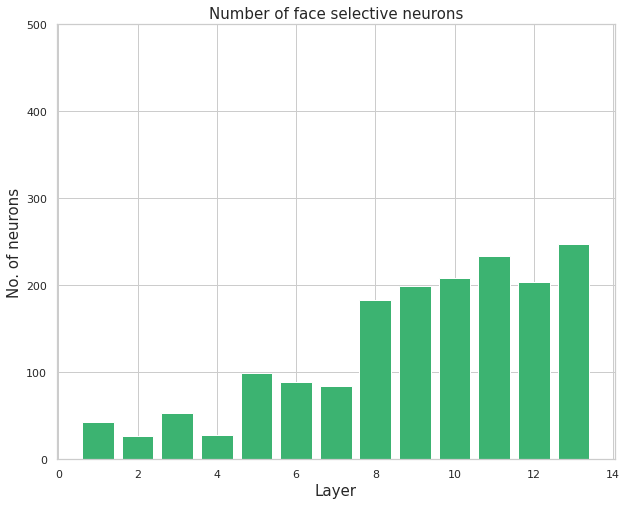

In [ ]:
idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

counter = np.zeros(13)
fig = plt.figure(figsize = (10,8))
for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      counter[layer] += 1
plt.bar(x = np.arange(1,14,1),
        height = counter,
        color = 'mediumseagreen')
plt.ylim(0,500)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of neurons',size = 15)
plt.title('Number of face selective neurons',size = 15)

Text(0.5, 1.0, 'Number of selective neurons, category wise')

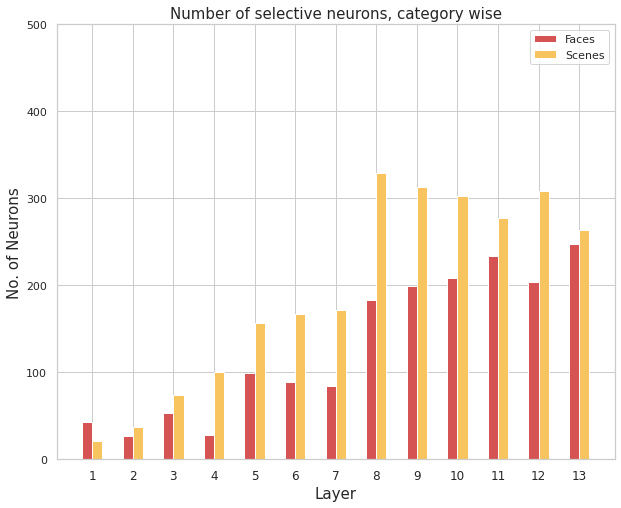

In [ ]:
width = 0.25

idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1



fig, ax = plt.subplots(figsize = (10,8))
rects1 = ax.bar(np.arange(13) - width/2 , c_face, width, label='Faces',color = '#D65353')
rects2 = ax.bar(np.arange(13) + width/2, c_scene, width, label='Scenes',color = '#F7C45F')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend()

plt.ylim(0,500)
plt.xticks(np.arange(13),np.arange(1,14),size = 12)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of Neurons',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)

#Gradient Calculations

In [ ]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
top_model.add(Dense(4, activation='softmax',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

g_labels_train = to_categorical(labels)
g_labels_test = to_categorical([0]* 40 + [1]*40 + [2]*40 + [3]*40)
g_train = np.vstack((reg_train[0],reg_train[1],reg_train[2],reg_train[3]))
g_test = np.vstack((reg_test[0],reg_test[1],reg_test[2],reg_test[3]))

G_train = model.predict(g_train)
G_test = model.predict(g_test)

history = top_model.fit(x = G_train,  y = g_labels_train,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

out = top_model.evaluate(G_test, g_labels_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
5/5 [==============================] - 0s 4ms/step - loss: 0.7634 - accuracy: 0.7312


In [ ]:
calc_gradient_val = 1
if calc_gradient_val:
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(ncats):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(data_train[i],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open('gradient_values_cat', 'wb') as fp:
      pickle.dump(cat_grads, fp)

In [ ]:
corr_all_2 = st.calc_all_corrcoeff(fc[0:2],cat_grads[0:2])
corr_all_1 = st.calc_all_corrcoeff(fc[2:4],cat_grads[2:4])

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


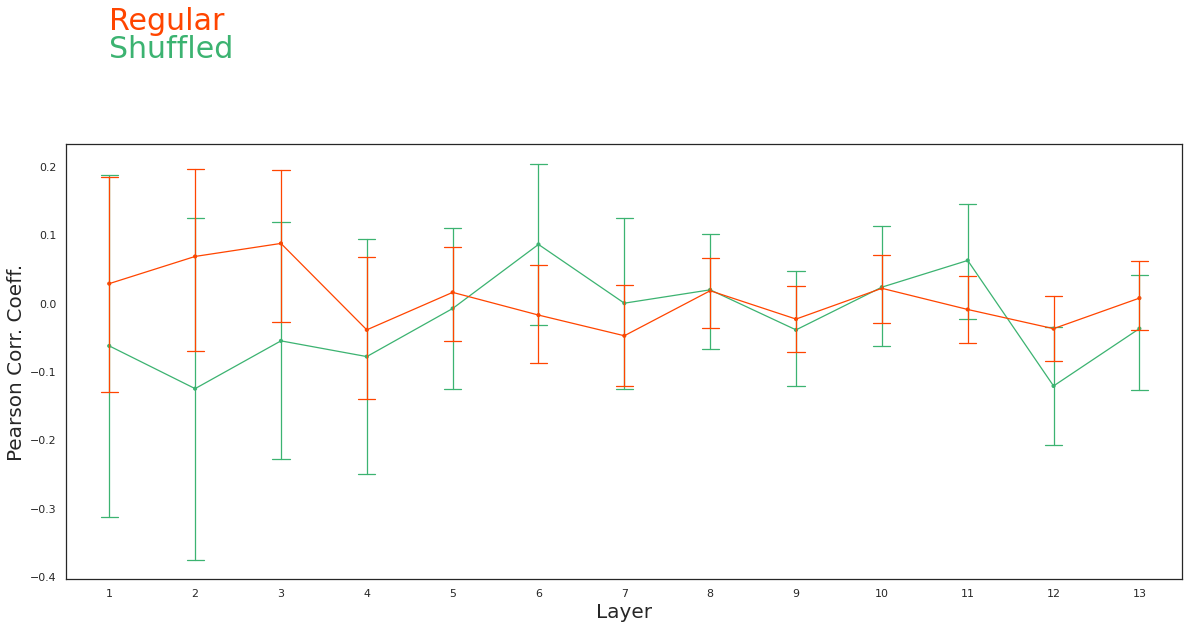

In [ ]:
import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)

for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)
pt.plot_corr(corr_all_1,corr_shuff,figsize = (20,8))

# Neuron level activities

### Calculate the tuning range of each neuron by computing its histogram of activity across all images.

In [ ]:
calc_neuron_activ = 1
ncats = 4
t_ranges = np.empty([ncats,len(train_it),13])

def rm_white(reg):
  r = np.random.uniform(0,1)
  for row in range(len(reg)):
    for col in range(len(reg[row])):
      for chan in range(len(reg[row,col])):
        if reg[row,col,chan] == 1:
          reg[row,col,chan] = np.random.uniform(0,1)
  return reg

if calc_neuron_activ:
  for cat in range(len(categories)): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    tun_activ = [[np.empty((224,224,64)),
              np.empty((224,224,64)),
              np.empty((112,112,128)),
              np.empty((112,112,128)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512))] for i in range(len(train_it))]


    start = time.time()
    for imgs,img_tensor in enumerate(train_it):
      #if cat == 0 or cat == 1:
        #img_tensor = rm_white(img_tensor)
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor,verbose = 0)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        #tun_activ[imgs][l] = layer_activation[0]
        t_ranges[cat][imgs][l] = np.mean(layer_activation[0])
      print(imgs)
      del intermediate_activations #important to clear memory
    
  print(f'Elapsed: {time.time() - start}s')

In [21]:
len(t_ranges[0])

80

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor 

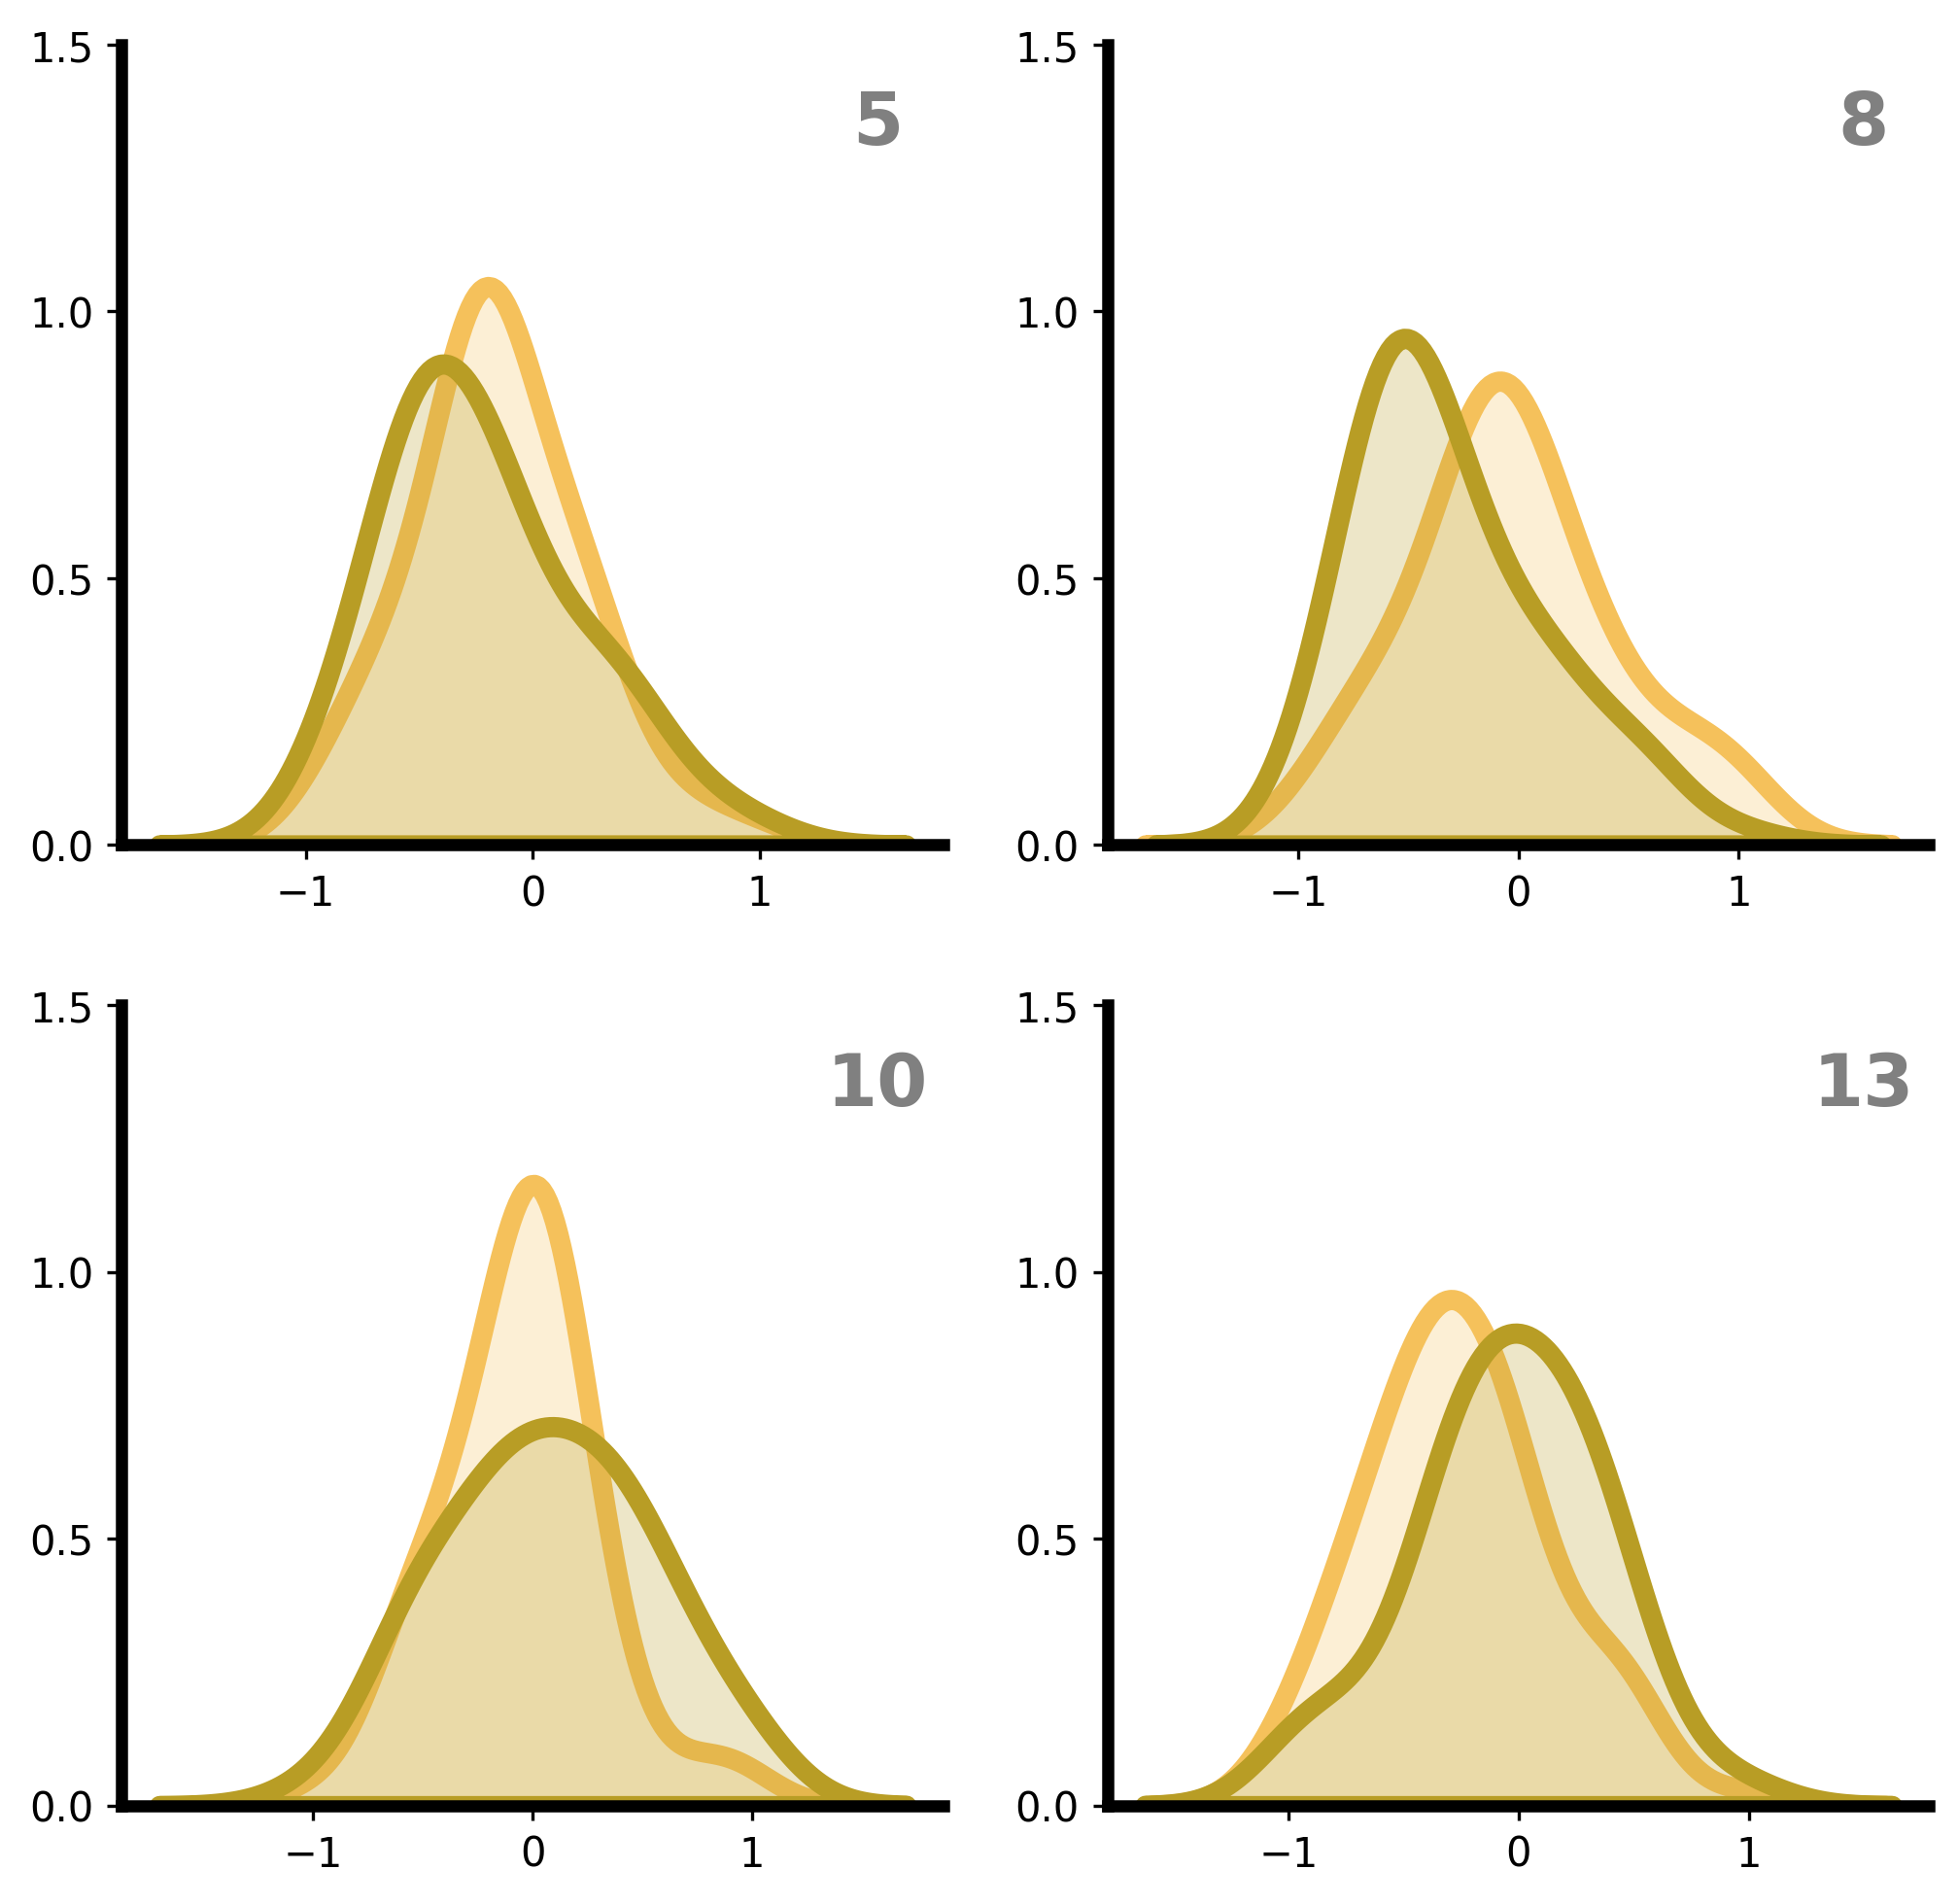

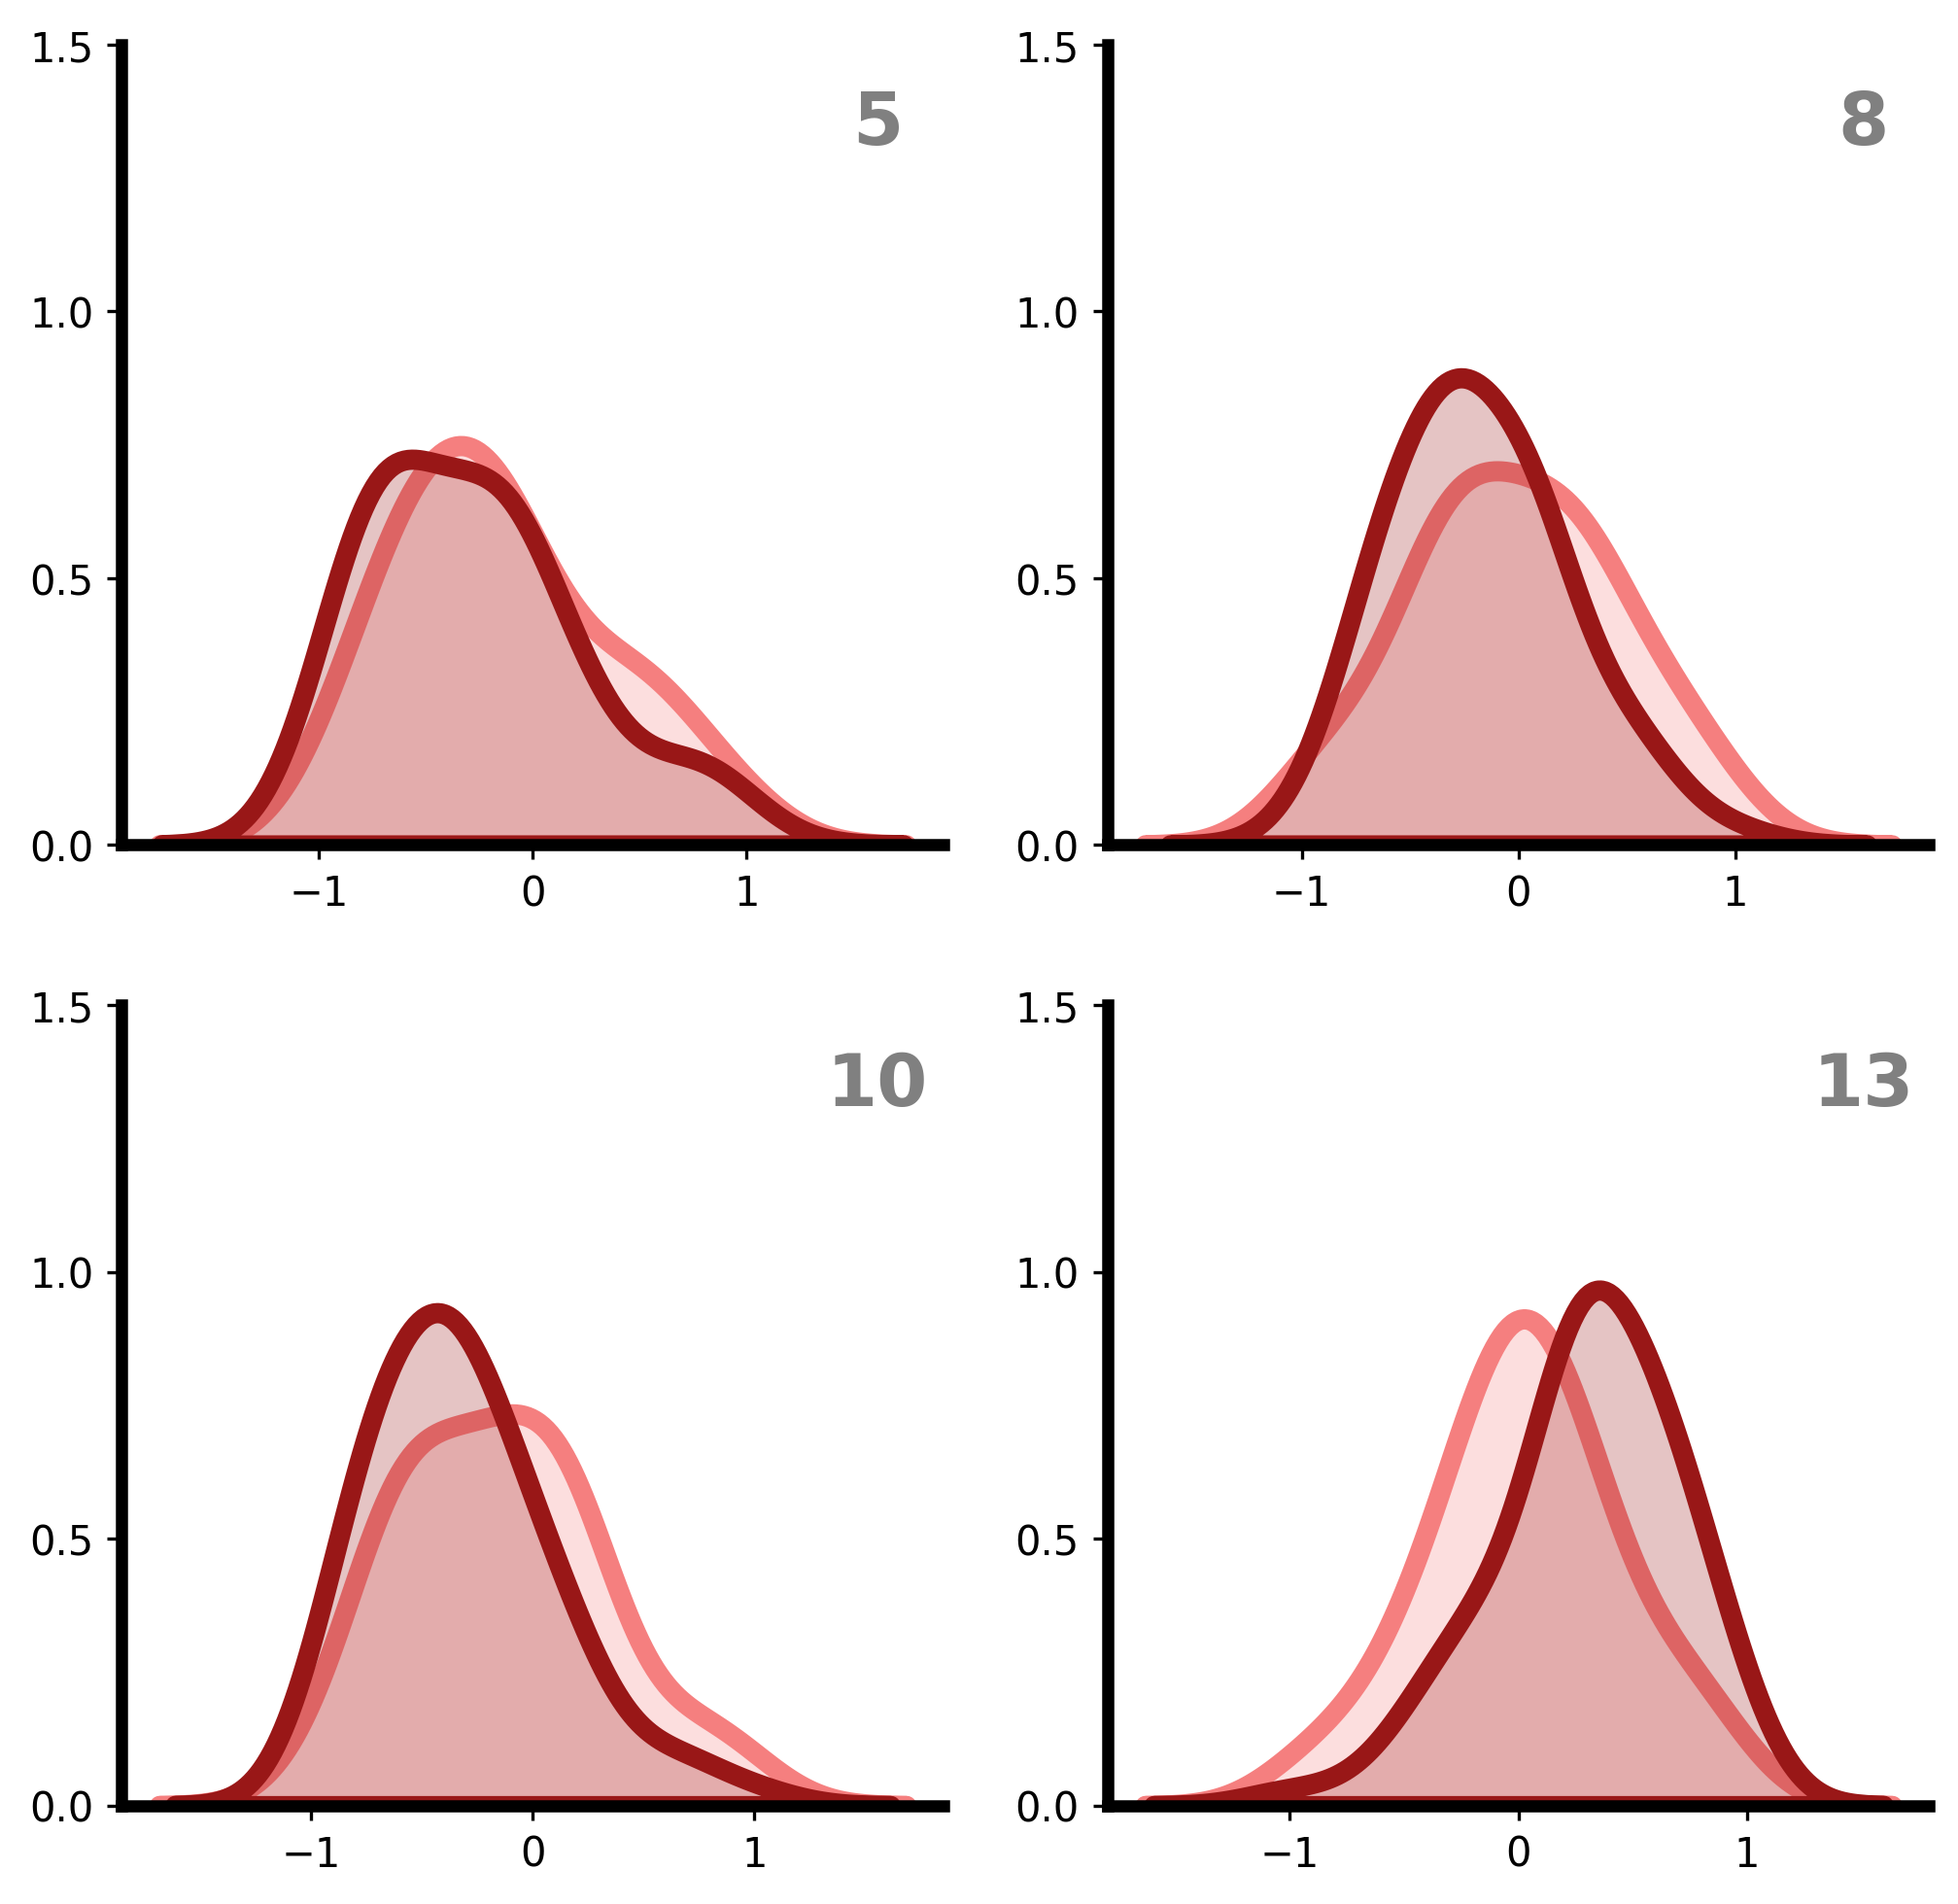

In [34]:
def my_norm(a):
  ratio = 2/(np.max(a)-np.min(a)) 
  shift = (np.max(a)+np.min(a))/2 
  return (a - shift)*ratio

def plot_tuning_range(a,b,a_col,b_col):
  layer_show = iter([4,7,9,12])
  fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8, 8))
  for row in ax:
    for col in row:
      l = next(layer_show)
      sns.kdeplot(np.array(my_norm(a[:,l])),bw = 0.5,ax = col,color = a_col,linewidth = 5,shade = True)
      sns.kdeplot(np.array(my_norm(b[:,l])),bw = 0.5,ax = col,color = b_col,linewidth = 5,shade = True)
      col.set_ylim(0,1.5)
      col.set_yticks([0,0.50,1,1.5])
      col.set_ylabel('')
      col.text(0.92, 0.9, str(l + 1), horizontalalignment='center',
              verticalalignment='center', transform=col.transAxes,
              color = 'gray',fontweight = 'semibold',fontsize = 18)
      col.spines['right'].set_visible(False)
      col.spines['top'].set_visible(False)
      col.spines['left'].set_linewidth(3)
      col.spines['bottom'].set_linewidth(3)
      col.tick_params(axis = 'both',labelsize=10)

plt.rcParams['figure.dpi'] = 300

face_range = np.concatenate((t_ranges[0,:,:],t_ranges[1,:,:]),axis = 0)
scene_range = np.concatenate((t_ranges[2,:,:],t_ranges[3,:,:]),axis = 0)
face1_range = t_ranges[0]
face2_range = t_ranges[1]
scene1_range = t_ranges[2]
scene2_range = t_ranges[3]


plot_tuning_range(scene1_range,scene2_range,'#f5c15b','#b89d25')
plt.savefig('/content/imtrain_suppl/imtrain_scene_tun_r.png')  # saves the current figure
plt.savefig('/content/imtrain_suppl/imtrain_scene_tun_r.jpeg')  # saves the current figure

plot_tuning_range(face1_range,face2_range,'#f57f7f','#991717')
plt.savefig('/content/imtrain_suppl/imtrain_face_tun_r.png')  # saves the current figure
plt.savefig('/content/imtrain_suppl/imtrain_face_tun_r.jpeg')  # saves the current figure

           
#plt.legend()



In [35]:
#!rm -rf imtrain_suppl
!zip -r plots.zip imtrain_suppl/

updating: imtrain_suppl/ (stored 0%)
updating: imtrain_suppl/imtrain_scene_tun_r.png (deflated 12%)
updating: imtrain_suppl/imtrain_face_tun_r.jpeg (deflated 38%)
updating: imtrain_suppl/imtrain_scene_tun_r.jpeg (deflated 39%)
updating: imtrain_suppl/imtrain_face_tun_r.png (deflated 13%)


In [36]:
from scipy.stats import ttest_ind,wilcoxon
for l in range(13):
  print('layer:', l+ 1)
  print(wilcoxon(face1_range[:,l],face2_range[:,l]))


layer: 1
WilcoxonResult(statistic=1208.0, pvalue=0.048146813030741635)
layer: 2
WilcoxonResult(statistic=1481.0, pvalue=0.504974052249303)
layer: 3
WilcoxonResult(statistic=1439.0, pvalue=0.3853242742469053)
layer: 4
WilcoxonResult(statistic=1204.0, pvalue=0.046015023707259586)
layer: 5
WilcoxonResult(statistic=1447.0, pvalue=0.40667580007934956)
layer: 6
WilcoxonResult(statistic=1536.0, pvalue=0.6870305282254063)
layer: 7
WilcoxonResult(statistic=1346.0, pvalue=0.18878473202968926)
layer: 8
WilcoxonResult(statistic=1509.0, pvalue=0.5944573788785863)
layer: 9
WilcoxonResult(statistic=1157.0, pvalue=0.026372577257563312)
layer: 10
WilcoxonResult(statistic=1155.0, pvalue=0.02572928839345724)
layer: 11
WilcoxonResult(statistic=857.0, pvalue=0.00025264165727175553)
layer: 12
WilcoxonResult(statistic=1013.0, pvalue=0.003598748848483582)
layer: 13
WilcoxonResult(statistic=1230.0, pvalue=0.061407202346100864)


### Calcuation of number of face and scene selective neurons

In [ ]:
width = 0.25

idx = [[-1 for item in subl] for subl in fc[0]] 
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1



fig, ax = plt.subplots(figsize = (10,8))
plt.rcParams['figure.dpi'] = 300

rects1 = ax.bar(np.arange(13) - width/2 , c_face, width, label='Faces',color = '#D65353')
rects2 = ax.bar(np.arange(13) + width/2, c_scene, width, label='Scenes',color = '#F7C45F')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend()

plt.ylim(0,500)
plt.xticks(np.arange(13),np.arange(1,14),size = 20)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of Neurons',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)

# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score

def gen_attnmap(modifier,mask,category,bi,atype,rand_map):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: bool, optional
        Set to 'True' for random set of tuning values
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10
  
    #conv1_1 & conv1_2

    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          
          amap = np.ones((224,224,64),dtype='float32') +  mask[layer]
        attnmap.append(amap)
        
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((112,112,128),dtype='float32') +  mask[layer]
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((56,56,256),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((28,28,512),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((14,14,512),dtype='float32') + mask[layer]
        attnmap.append(amap)
    
    
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1,
                 rand_map = 0):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: int, optional
        0 = No randomization
        1 = Shuffled tuning values
        2 = Same tuning values
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    
    epochs = 30    
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype,rand_map)     
        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()
        
        f_train = model.predict(data_train)     
    
        f_test = model.predict(data_test)
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)

        
        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])
    
        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1:5]

    return t_acc



### Driver
This is the big loop which applies attention at each layer separately as a function of different attentional strengths. 
PS. This is very heavy and requires hours to finish.


In [ ]:
##@title Multiplicative and bidirectionality corrected

from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
initializer = tf.keras.initializers.RandomNormal(mean = 0,stddev = 1)
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1',kernel_initializer = initializer)) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense2',kernel_initializer = initializer)) 

top_model.add(Dense(2, activation='softmax',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.TruePositives(),
                     tf.keras.metrics.TrueNegatives(), 
                     tf.keras.metrics.FalsePositives(), 
                     tf.keras.metrics.FalseNegatives(), 
                     tf.keras.metrics.AUC()])

model = VGG16(weights='imagenet',
                    include_top=False,input_shape = [224,224,3])
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(0,10,1): #Calling for different attn strengths
  grand_acc = [[] for i in range(ncats)] 
  for cat in range(ncats): # Iterating over 6 categories
    #tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Testing on merged data
    print(train_it.shape,test_it.shape)

          
    
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1,
                              rand_map = 2 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([4,13])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('tun_accuracy_multi' + str(atstrng),grand_acc)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 1s 8ms/step - loss: 755.4490 - accuracy: 0.5500 - true_positives: 44.0000 - true_negatives: 44.0000 - false_positives: 36.0000 - false_negatives: 36.0000 - auc: 0.5500


ValueError: ignored

In [ ]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('tun_accuracy_new' + str(atstrng),grand_acc)

ValueError: ignored

### Effects of varying attention strength for layer

In [ ]:
# Load the data +  '/vgg_face/'
data = [[[[] for j in range(20) ]for k in range(6)] for i in range(13)]
attentionIndex = 0;
for atstrng in np.arange(0,10,0.5): 
  temp = np.load(root_directory + 'tun_accuracy_multi' + str(atstrng)+'.npy')
  for cat in range(6):
    for layer in range(13):
      data[layer][cat][attentionIndex] = temp[cat][layer]
  attentionIndex += 1;

In [ ]:
# Calculate the del_FPR, del_TPR
del_FPR = [[[ ]for k in range(6)] for i in range(13)]
del_TPR = [[[ ]for k in range(6)] for i in range(13)]
for attention in range(0, 20): 
  for cat in range(6):
    for layer in range(13):
      # 'accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC()
      # Del_To_attention_0.0
      # del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4]))-(data[layer][cat][0][1] / (data[layer][cat][0][1]+data[layer][cat][0][4])));
      # del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2]))-(data[layer][cat][0][3] / (data[layer][cat][0][3]+data[layer][cat][0][2])));
      # No_Del
      del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4])));
      del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2])));
      # Del_to_original
      # del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4]))-(acc[1][cat][1] / (acc[1][cat][1]+acc[1][cat][4])));
      # del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2]))-(acc[1][cat][3] / (acc[1][cat][3]+acc[1][cat][2])));
      

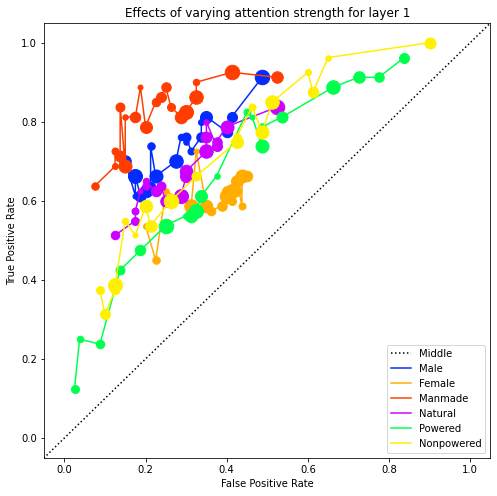

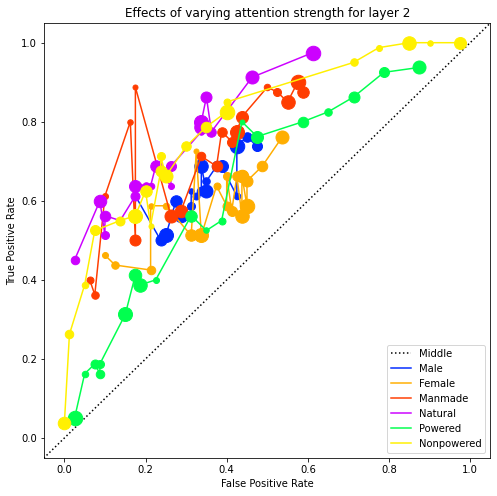

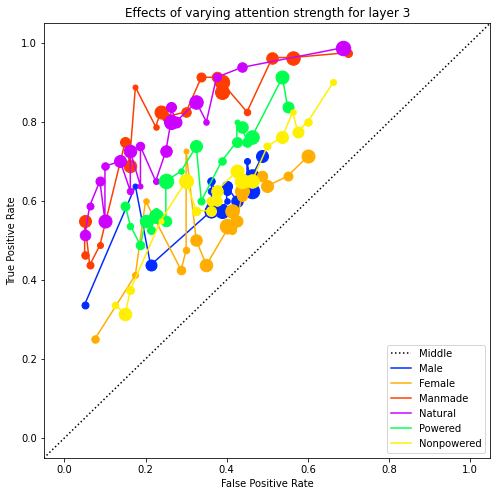

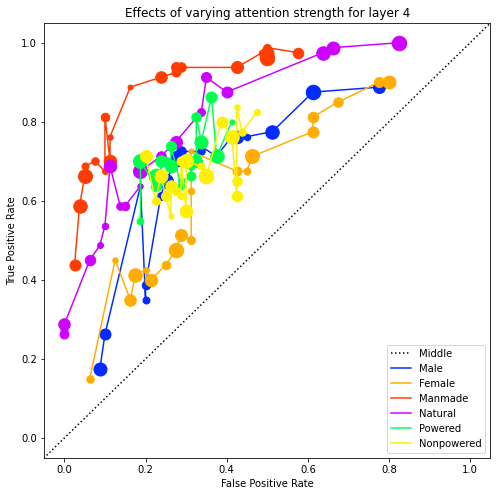

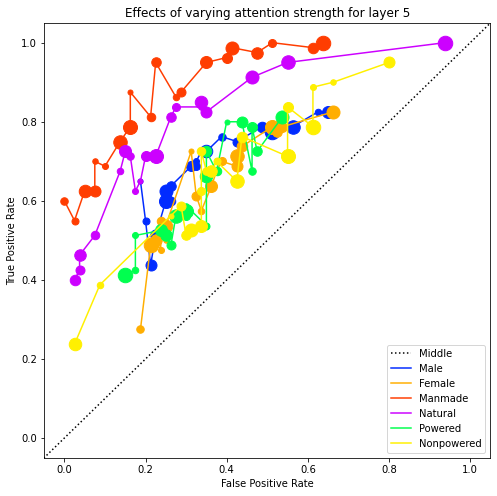

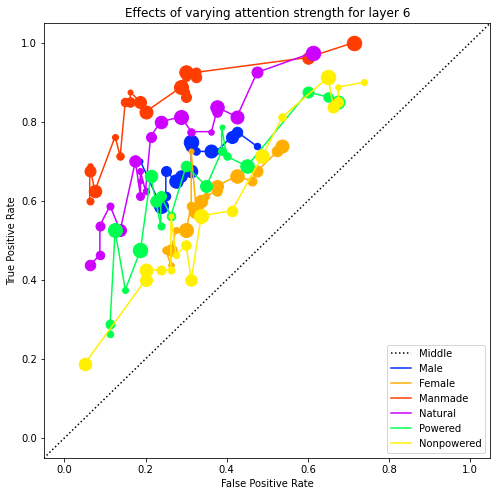

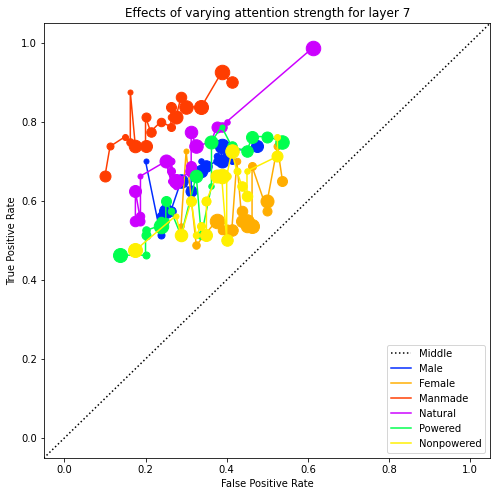

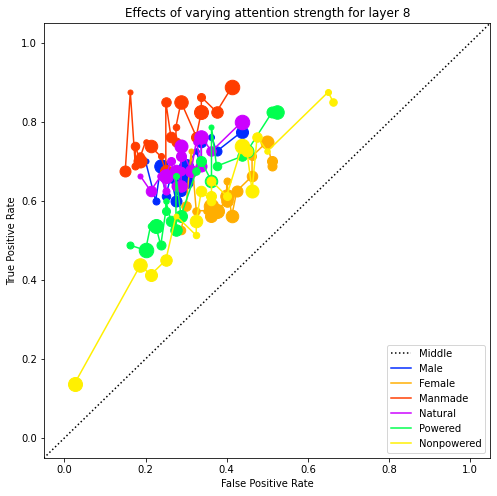

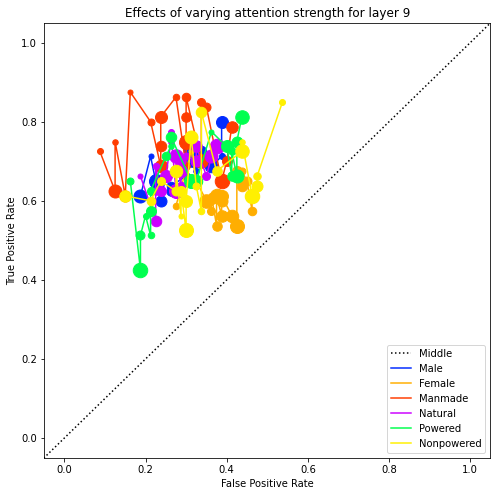

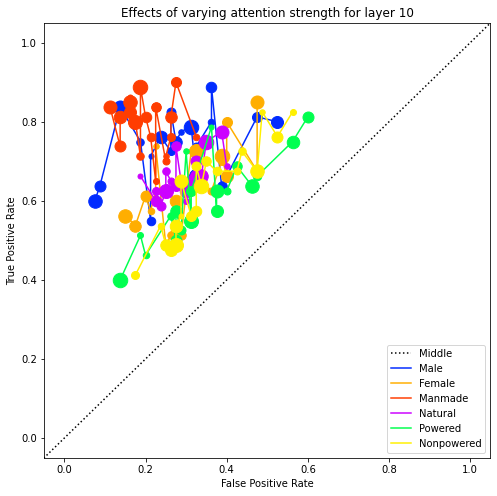

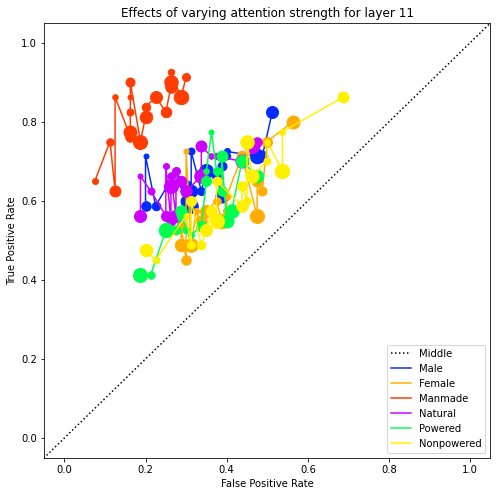

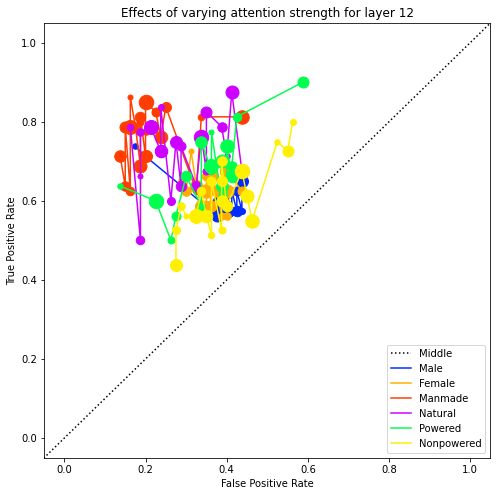

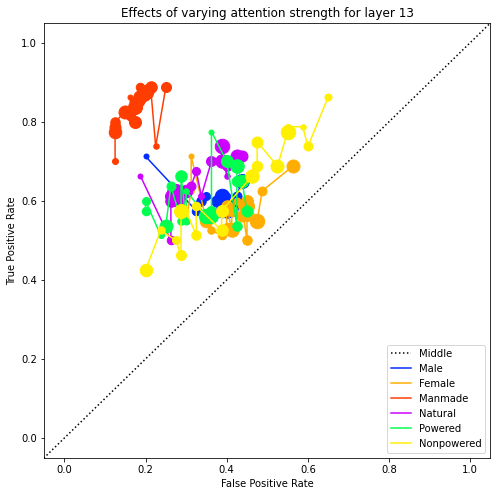

In [ ]:
import matplotlib.pyplot as plt

colors = ['#012bff','#ffae01','#ff3d01','#cc01ff','#01ff4f','#fff001']

for figureNumber in range(13): # iterate over all of the layers
  plt.figure(figsize = (8,8))
  plt.xlim([-0.05, 1.05]) 
  plt.ylim([-0.05, 1.05])
  plt.xlabel('\u0394 False Positive Rate')
  plt.ylabel('\u0394 True Positive Rate') 
  plt.title('Effects of varying attention strength for layer ' + str(figureNumber + 1 ))
  plt.plot([-2,2], [-2,2], ':',label='Middle', color='black')
  for i in range(6):
    markersize = [ 5+(i/2) for i in range(20)]
    processed = list(zip(del_FPR[figureNumber][i], del_TPR[figureNumber][i], markersize))
    sortedProcessed= sorted(processed,key=lambda item: (item[0],item[1]))
    unzipped = list(zip(*sortedProcessed))
    # print(unzipped)
    # print(list(unzipped[0]))
    plt.plot(list(unzipped[0]),list(unzipped[1]), 'k',label=categories[i], color=colors[i])
    for k in range(20):
      plt.plot(sortedProcessed[k][0], sortedProcessed[k][1],'bo', markersize = sortedProcessed[k][2], color=colors[i])
  plt.legend(loc="lower right")
  # plt.savefig(root_directory + 'figures/layer_'+str(figureNumber+1)+'.png')
  # Save the figures using Vggface model +  '/vgg_face' 
  plt.savefig(root_directory + '/figures/no_del/layer_'+str(figureNumber+1)+'.png')
plt.show()

In [ ]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
          
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(1, activation='sigmoid',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy'])
    
categories = ['Male','Female','Manmade','Natural']
acc = [0]*4
for cat in range(ncats):
  tf.keras.backend.clear_session()

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 4]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 4]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it) 

  features_test = model.predict(test_it) 


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 80
  train_data = features_train
  train_labels = np.array([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = np.array([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

# Calculation for control condition

Text(0.5, 0, 'Category')

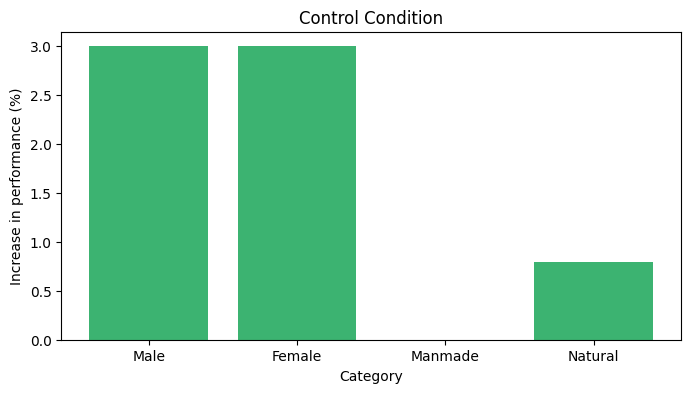

In [ ]:
plt_data = np.array((3,3,0,0.8))
fig = plt.figure(figsize = (8,4))
plt.bar(x = ['Male','Female','Manmade','Natural'],
        height = plt_data.T,
        color = 'mediumseagreen')
plt.title('Control Condition')
plt.ylabel('Increase in performance (%)')
plt.xlabel('Category')


# Plots

### Layer wise plot
This code generates the plot for performance increase as a function of attention applied at each layer separately.

Text(0, 0.5, 'Performance Increase (%)')

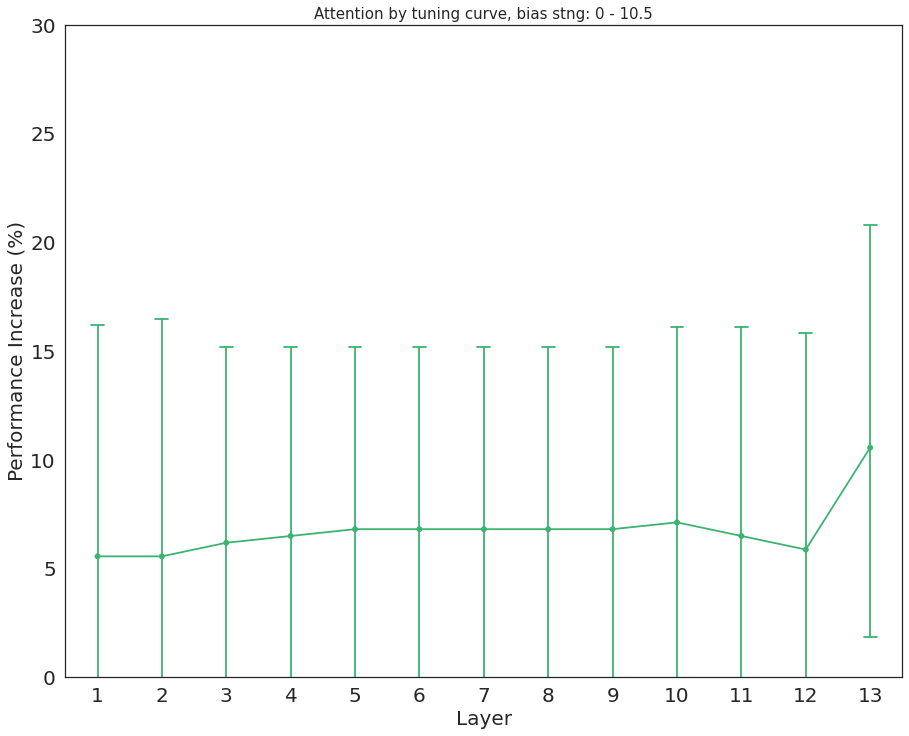

In [ ]:
acc = [0.69,0.72,0.85,0.58]
import numpy as np
import matplotlib.pyplot as plt

x = np.load('tun_accuracy_multi0.npy')
x = np.expand_dims(x,0)

for i in np.arange(1,10,1):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))



x = np.amax(x,0)

plt_data = np.zeros((ncats,13))
for i in range(ncats):
  for j in range(13):
    plt_data[i,j] = x[i,j] - acc[i]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = plt_data*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
                   
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
plt.yticks(fontsize = 20)
plt.ylim(0,30)
plt.title('Attention by tuning curve, bias stng: 0 - 10.5',size = 15)
ax.set_ylabel('Performance Increase (%)',size = 20)

### Category wise plot
This code generates the plot for performance increase as a function of category and attention applied at each layer separately.

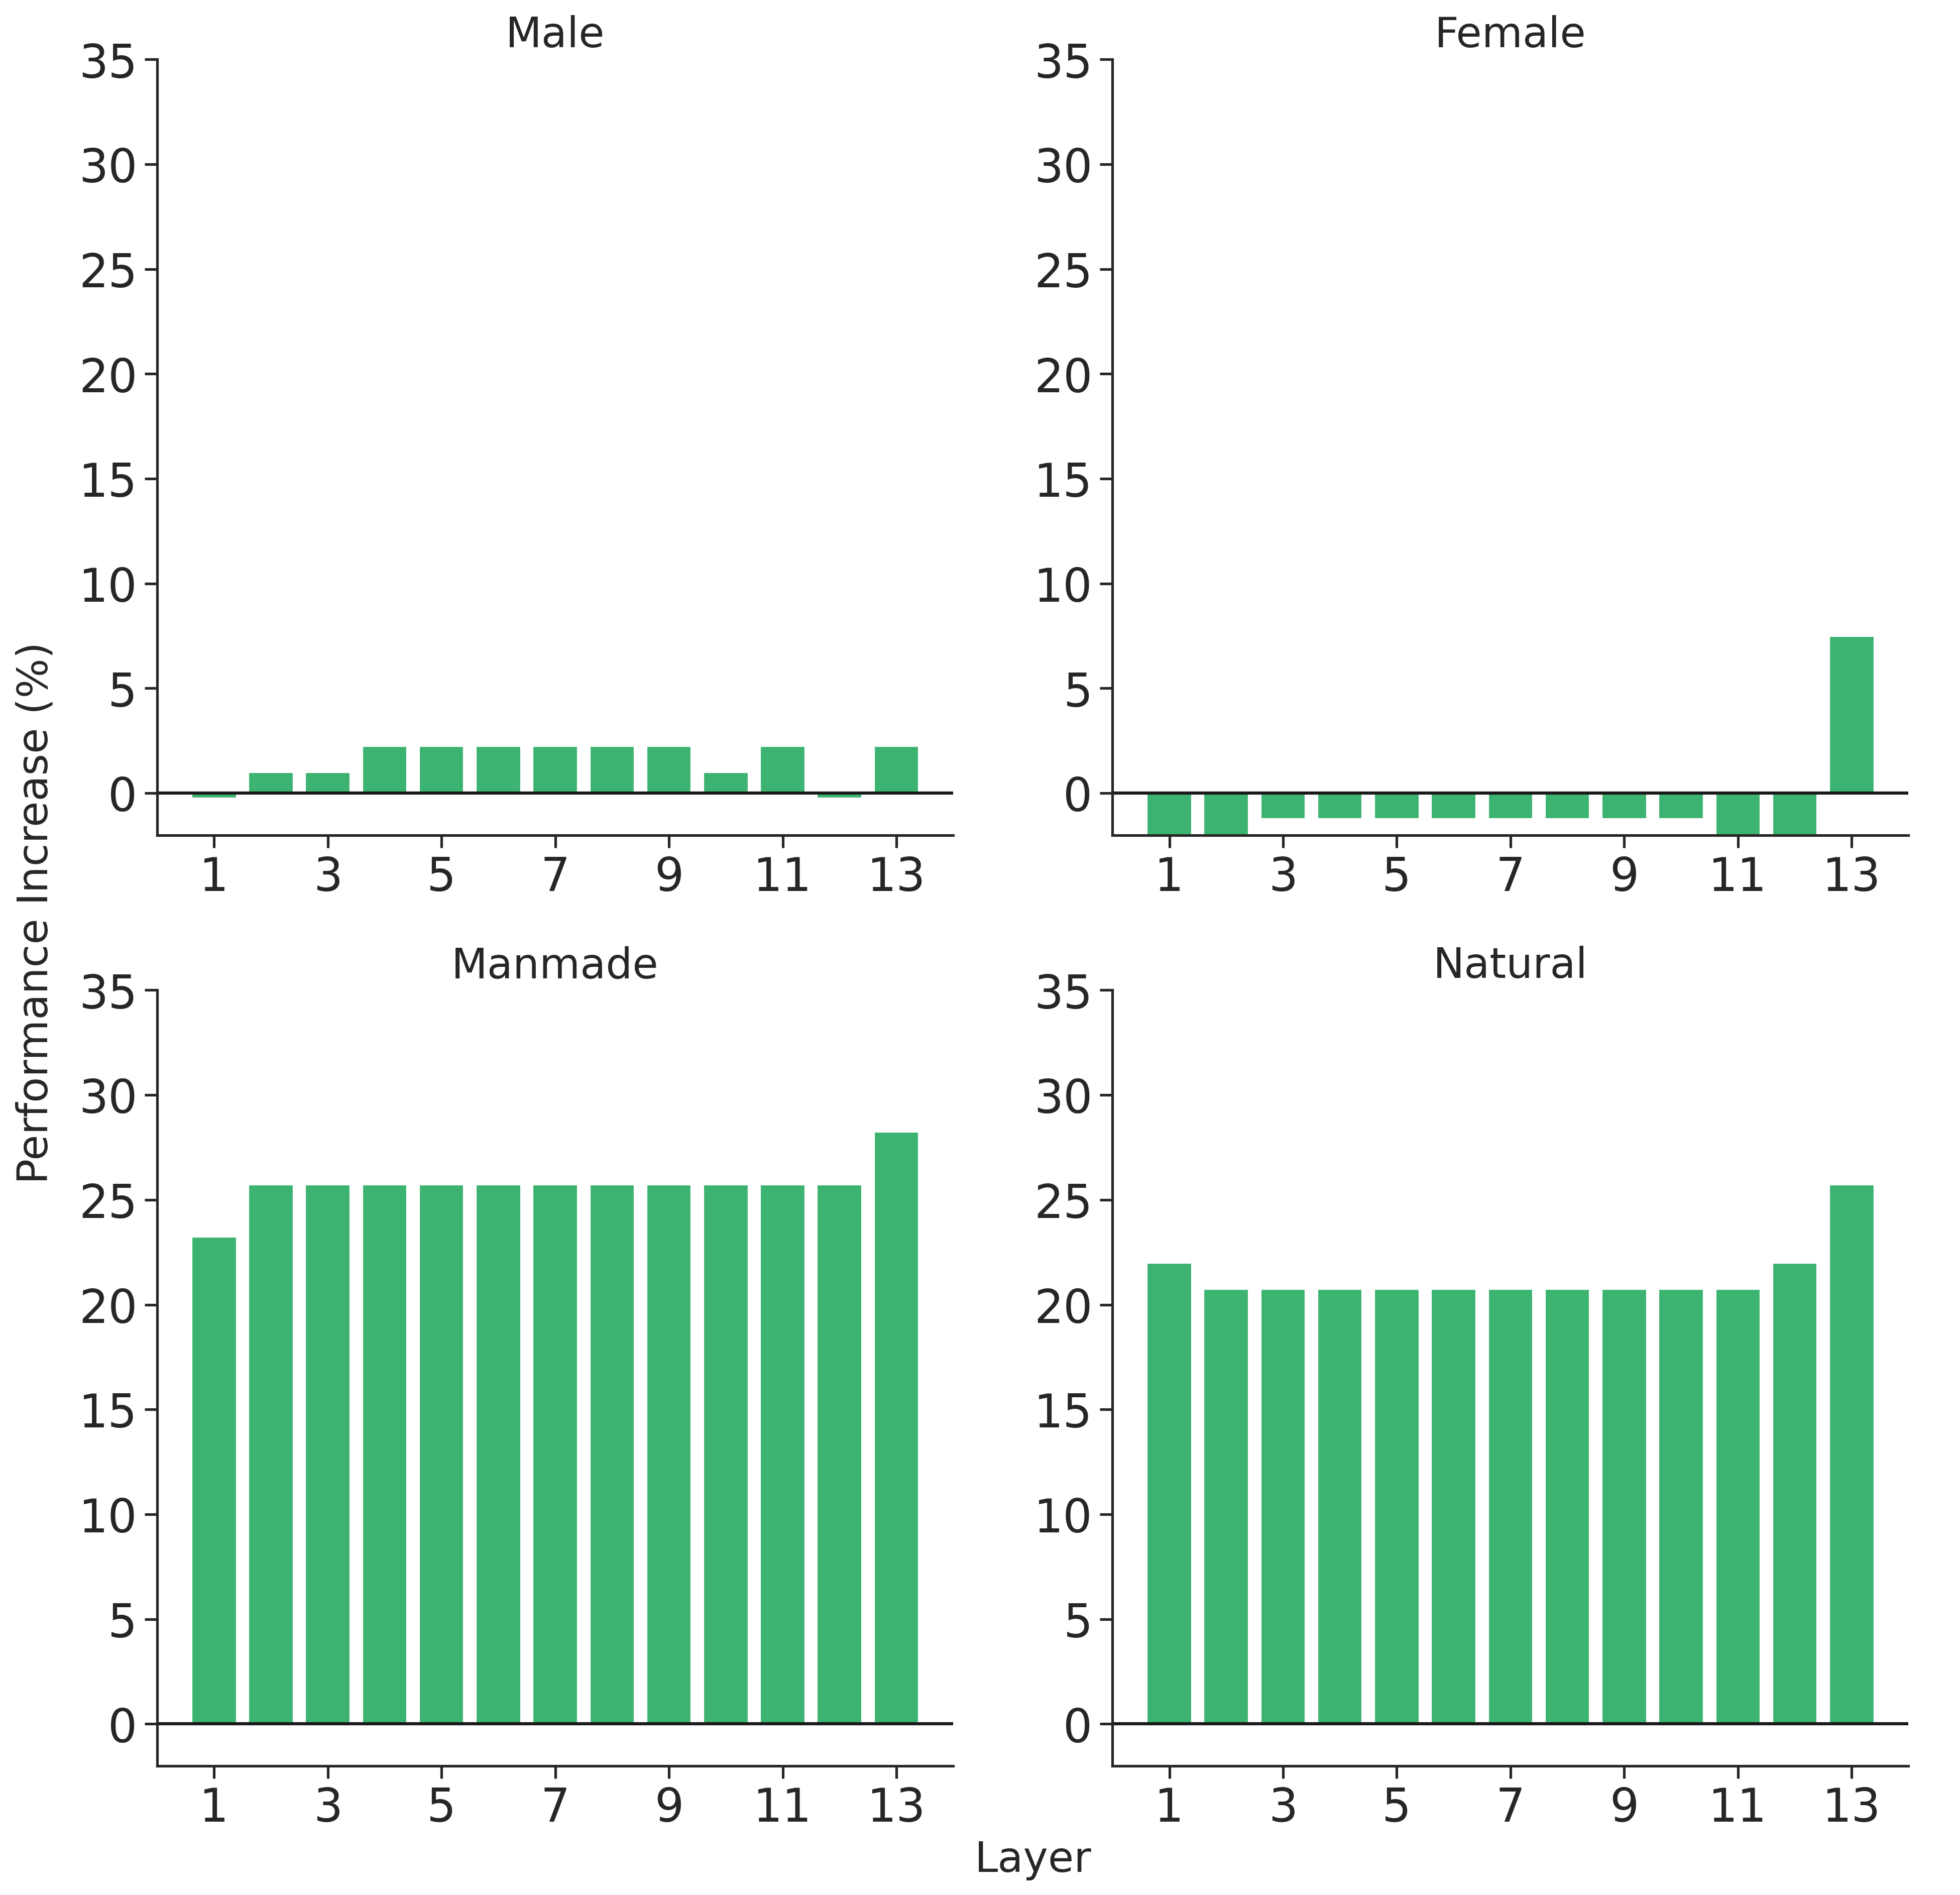

In [ ]:
acc = [0.69,0.70,0.68,0.58]

gacc = np.load('tun_accuracy_multi0.0.npy')
gacc = np.expand_dims(gacc,0)


for i in np.arange(0.5,10,0.5):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
#strngs = np.concatenate((strngs,np.arange(1,6,1)))
y = np.amax(gacc,0).T


plt_data = np.zeros((13,4))
for i in range(13):
  for j in range(4):
    plt_data[i,j] = y[i,j] - acc[j]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
sns.set(font_scale=2,style='ticks')
layer = 0
plt.rcParams['figure.dpi'] = 300
f,axes = plt.subplots(2,2,figsize=(15,15))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Layer",size = 20)
plt.ylabel("Performance Increase (%)",size = 20)
for x in range(2):
  for y in range(2):
    axes[x,y].bar(x = np.arange(0,13),height = plt_data[:,layer]*100,color = 'mediumseagreen')
    axes[x,y].set_xticklabels(np.arange(1,14,2))
    axes[x,y].set_xticks(np.arange(0,14,2))
    axes[x,y].set_title(categories[layer],size = 20)
    axes[x,y].set_ylim(-2,35)
    axes[x,y].set_xlim(-1,13)
    axes[x,y].hlines(y = 0,xmin= -1,xmax = 13)
    axes[x,y].spines['right'].set_visible(False)
    axes[x,y].spines['top'].set_visible(False)
    layer+=1
  
np.save('merge_set.npy',plt_data)